In [1]:
import torch
from torch import nn
import numpy as np
from torch.utils.data import DataLoader
# import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, random_split, DataLoader
from torch import nn
import pandas as pd

In [3]:
from fast_histogram import histogram2d
import constants as c


ModuleNotFoundError: No module named 'constants'

In [4]:
background_file = '/isilon/data/users/jpfeife2/AutoEncoder-Anomaly-Detection/processed_data/background_small.pkl'
signal_file = '/isilon/data/users/jpfeife2/AutoEncoder-Anomaly-Detection/processed_data/signal_small.pkl'
background = pd.read_pickle(background_file)
signal = pd.read_pickle(signal_file)

In [5]:
ETA_MIN = -0.8 
ETA_MAX = 0.8 
PHI_MIN = -0.8 
PHI_MAX = 0.8 
INCR = 0.05 
BINS = int(abs(ETA_MIN - ETA_MAX)/INCR)

In [6]:
# def load_1D(data): 
#     reshaped_data = []
#     eta = data['eta']
#     phi = data['phi']
#     pt = data['pt']
#     reshaped_data.append([np.column_stack([eta[i], phi[i], pt[i]]) for i in range(data.shape[0])])
#     return reshaped_data


In [7]:
def make_histogram(eta, phi, cc):
    hist_range = [[ETA_MIN, ETA_MAX], [PHI_MIN, PHI_MAX]]
    eta_bins = np.arange(ETA_MIN, ETA_MAX, INCR)
    phi_bins = np.arange(PHI_MIN, PHI_MAX, INCR)
    image_shape = (eta_bins.shape[0], phi_bins.shape[0])

    return histogram2d(phi, eta, range=hist_range, bins=image_shape, weights=cc)

def format_2D(data):
    print("==============================")
    print(data["eta"][0])

    hist = [make_histogram(data['eta'][i], data['phi'][i],data['pt'][i]) for i in range(data.shape[0])]
    hist = np.reshape(hist, (-1, BINS, BINS, 1))
    return hist

In [8]:
reshaped_data = format_2D(background)
signal_data = format_2D(signal)
# reshaped_data = torch.tensor(reshaped_data, dtype = float)

[-0.020996094, 0.010498047, 0.017578125, -0.0014648438, -0.015136719, -0.0026855469, -0.05883789, -0.023925781, 0.088134766, -0.16625977, 0.052978516, 0.08154297, -0.38916016, -0.36791992, 0.60253906, -0.2602539, -0.012451172, 0.18432617, -0.41796875, 0.53222656]
[0.70947266, -0.14517212, 0.25732422, 0.061584473, 0.1282959, 0.07342529, 0.04498291, 0.14941406, -0.06048584, 0.11010742, 0.13812256, 0.46984863, 0.09643555, 0.009033203, 0.08648682, 0.1251831, 0.04724121, 0.13372803, -0.030212402, 0.030212402, 0.20800781, 0.076049805, -0.42064667, -0.32427216, -0.13684082, -0.39214325, -0.27903748, -0.1723938, -0.26020813, -0.230896, -0.30512238, -0.19262695, -0.236969, 0.08886719, -0.18041992, -0.38862228, 0.14367676, 0.16320801, -0.28071594, -0.47192383, -0.11682129, -0.1777649, -0.17797852, -0.08581543, -0.06829834, -0.1411438, 0.057800293, 0.08081055, -0.26927185, -0.17181396, -0.39985657, -0.38277435, -0.40296936]


In [9]:
print(reshaped_data[0].shape)

(32, 32, 1)


In [34]:
class TransformerAnomalyDetection(nn.Module):
    # Autoencoder with attention.
    def __init__(self, input_size=(32, 32, 1), latent_dim=32*32*1, num_heads=4, num_layers=6):
        super().__init__()
        self.input_size = input_size
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        # Encoder layers
        encoder_layers = nn.TransformerEncoderLayer(d_model=np.prod(input_size), nhead=num_heads, dropout=0.2, activation='relu', dim_feedforward=36)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        # Decoder layers
        decoder_layers = nn.TransformerDecoderLayer(d_model=np.prod(input_size), nhead=num_heads, dropout=0.2, activation='relu', dim_feedforward=36)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layers, num_layers=num_layers)
        # Linear layers for encoding and decoding
        self.encoder_linear = nn.Linear(np.prod(input_size), latent_dim)
        self.decoder_linear = nn.Linear(latent_dim, np.prod(input_size))

    def forward(self, x):
        # Flatten input
        x = x.float()
        x_flat = x.view(x.size(0), -1)  # Reshape to (batch_size, input_size)     
        # x_flat = [i.float() for i in x_flat]  
        # Encode
        # print(x_flat.shape)
        encoded = self.encoder_linear(x_flat)  # (batch_size, latent_dim)
        encoded = encoded.unsqueeze(1)  # Add sequence length dimension (batch_size, seq_len=1, latent_dim)  
        # Transformer Encoder
        encoded = self.transformer_encoder(encoded)  # (batch_size, seq_len=1, latent_dim)
        # Decode
        decoded = self.decoder_linear(encoded.squeeze(1))  # (batch_size, prod(input_size))      
        return decoded

In [35]:
def train_loop(dataloader, model, loss_func, optimizer, batch_size):
    # Train a model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    train_loss = 0
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    for batch, X in enumerate(dataloader): # for batch, (X,y) in ... for labelled data.
        X = X.to(device)
        pred = model(X)
        loss = loss_func(pred, X.float()) # X -> y
        
        # Backpropogation.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

        if batch % 100 == 0:
            current = batch * batch_size + len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
        
    train_loss /= num_batches
    print(f"Average train loss over the number of batches: {train_loss:>8f} \n")
        
    return train_loss

    
def test_loop(dataloader, model, loss_func):
    # Test a model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    test_loss = 0
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    with torch.no_grad(): # No gradient calculated.
        for X in dataloader: # for (X,y) in ... for labelled data.
            X = X.to(device)
            pred = model(X)
            test_loss += loss_func(pred, X).item() # X -> y
            # correct += (pred.argmax(1) == X).type(torch.float).sum().item() # Does not make sense with autoencoders.

    test_loss /= num_batches
    print(f"Average test loss over the number of batches: {test_loss:>8f} \n")
    
    return test_loss

def train_model(dataloader_train, dataloader_test, model, loss_func, optimizer, epochs, 
                scheduler=None, batch_size=32, graph_path=None):
    # Training and testing (or validation).
    train_loss = np.zeros(epochs)
    test_loss = np.zeros(epochs)
    
    for t in np.arange(0, epochs, step=1):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss[t] = train_loop(dataloader_train, model, loss_func, optimizer, batch_size=batch_size)
        test_loss[t] = test_loop(dataloader_test, model, loss_func)
        print("Done!")

        if scheduler:
            scheduler.step() # Update learning rate.
            current_lr = scheduler.get_last_lr() # Print the current learning rate
            print(f"Current learning rate: {current_lr[0]}")

    visualization(train_loss, test_loss, graph_path) # Plot and save graphs.

    return train_loss, test_loss

def evaluate_model(dataloader_test, model, loss_func):
    # Model evaluation.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    test_loss = np.zeros(len(dataloader_test))
    with torch.no_grad():
        for ind, X in enumerate(dataloader_test):
            X = X.float() 
            X = X.to(device)
            pred = model(X)
            test_loss[ind] = loss_func(pred, X).item()
    return test_loss
            
def visualization(train_loss, test_loss, graph_path):
    # Plot two types of graphs - with background (for report) and without (for slides).
    graph_text_face = [('white', 'none'), ('black', 'white')]
    for (text_color, face_color) in graph_text_face:
        fig, ax = plt.subplots(figsize=(10, 4), facecolor=face_color)
        ax.plot(train_loss, label="Training loss")
        ax.plot(test_loss, label="Validation loss")
        ax.set_title("Loss Progression", color=text_color)
        ax.set_xlabel("Epoch number", color=text_color)
        ax.set_ylabel("Reconstruction loss", color=text_color)
        ax.legend(facecolor=face_color)
        ax.tick_params(axis='both', colors=text_color)
        plt.tight_layout() # Remove empty edges.
        if graph_path:
            plt.savefig(graph_path.replace('.png', f'_{face_color}.png'), dpi=600, bbox_inches='tight')
        plt.show()

def exp_scheduler(optimizer, gamma):
    # Scheduled learning rate: lr_0 * exp(-gamma * iter_num).
    return torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

In [36]:
X_train = X_test = reshaped_data
# X_train = reshaped_data[:15]
# X_test = reshaped_data[16:]
X_valid = signal_data

In [37]:
print(X_train.shape)

(20, 32, 32, 1)


In [43]:

# Hyperparameters.
learning_rate = 1e-5
weight_decay = 1e-3 # For l2 regularization.
batch_size = 1
epochs = 10

In [44]:
torch.manual_seed(42)
X_train_dataloader = DataLoader(X_train, batch_size=batch_size, shuffle=True)
X_test_dataloader = DataLoader(X_test, batch_size=batch_size, shuffle=True)
X_valid_dataloader = DataLoader(X_valid, batch_size=batch_size, shuffle=True)

In [45]:
print(X_train_dataloader)

In [46]:
# Choose model, loss function, optimizer, and learning rate scheduler.
model = TransformerAnomalyDetection()
print(model)
loss_func = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# scheduler = exp_scheduler(optimizer=optimizer, gamma=0.95) # If we use a scheduled learning rate.

TransformerAnomalyDetection(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (linear1): Linear(in_features=1024, out_features=36, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=36, out_features=1024, bias=True)
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=

Epoch 1
-------------------------------


/isilon/data/users/jpfeife2/miniforge3/envs/anomaly/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 32, 32, 1])) that is different to the input size (torch.Size([1, 1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.330490  [    1/   20]
Average train loss over the number of batches: 0.245996 

Average test loss over the number of batches: 0.152306 

Done!
Epoch 2
-------------------------------
loss: 0.194094  [    1/   20]
Average train loss over the number of batches: 0.147864 

Average test loss over the number of batches: 0.079664 

Done!
Epoch 3
-------------------------------
loss: 0.122791  [    1/   20]
Average train loss over the number of batches: 0.098410 

Average test loss over the number of batches: 0.042045 

Done!
Epoch 4
-------------------------------
loss: 0.114860  [    1/   20]
Average train loss over the number of batches: 0.075907 

Average test loss over the number of batches: 0.024394 

Done!
Epoch 5
-------------------------------
loss: 0.063467  [    1/   20]
Average train loss over the number of batches: 0.068908 

Average test loss over the number of batches: 0.016294 

Done!
Epoch 6
-------------------------------
loss: 0.049318  [    1/   20]
Average train l

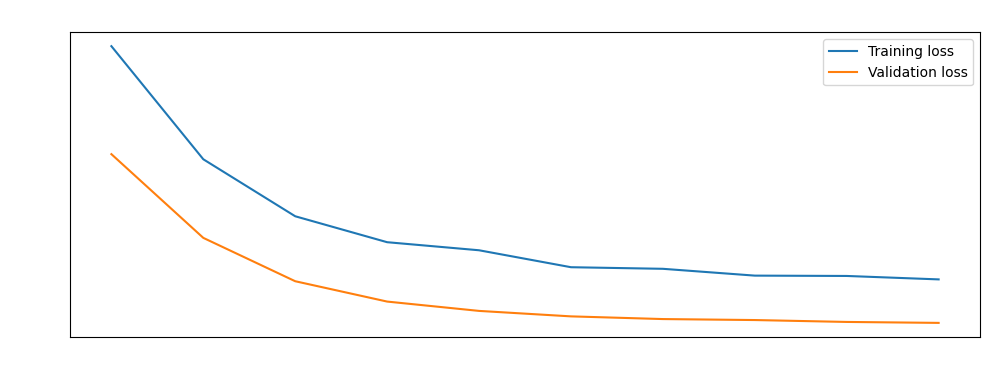

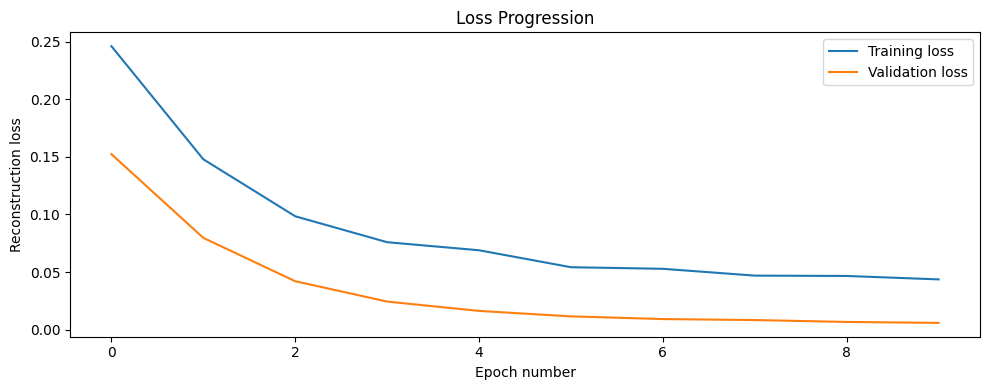

In [47]:
# Train the model on the background data, plot, and save it.
torch.set_num_threads(2)
train_loss, valid_loss = train_model(
    X_train_dataloader, 
    X_valid_dataloader, 
    model, 
    loss_func, 
    optimizer, 
    epochs, 
    scheduler=None,
    batch_size=batch_size, 
    graph_path=''
)